# 3-6. 프로젝트: 고양이 수염 스티커 만들기
인물 사진에서 얼굴을 검출하고 적절한 위치에 고양이 수염을 출력한다

## 1. 이미지 준비
- 얼굴 영역 검출과 landmark 검출 테스트를 위해 `Lenna` 이미지를 준비

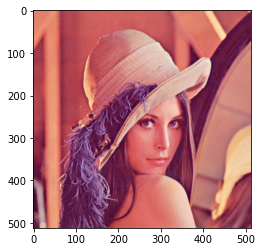

In [1]:
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np


img_bgr = cv2.imread("lenna.png", cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_bgr.copy()
plt.imshow(img_rgb)
plt.show()


- dlib 라이브러리를 사용하여 사진 속에서 얼굴을 검출
  - dlib에서는 이미지 피라미드를 구성하고 슬라이딩 윈도우 방식으로 탐색
  - HOG(Histogram of Oriented Gradients) 특성 사용
    - gradient와 orientation을 사용하여 특징 기술

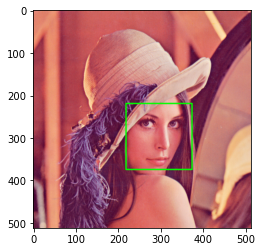

In [2]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_bgr, 1)

# print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


## 2. Landmark 검출

- 훈련되어 있는 predictor를 사용
  - 총 68개의 landmark를 결과로 출력
- 완전한 정면이 아님에도 코와 눈, 얼굴 윤곽과 같은 부분들이 잘 검출되었음

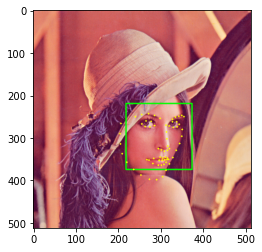

In [3]:
landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


## 3. 스티커 이미지 준비

- 얼굴의 중앙이라고 할 수 있는 코의 좌표 `landmark[30]`를 사용하여 스티커를 붙일 위치 지정

In [4]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    w = h = dlib_rect.width()
    x = landmark[30][0]
    y = landmark[30][1] + w // 2
    print(f"(x,y) : ({x}, {y})")
    print(f"(w,h) : ({w}, {h})")



(316, 319)
(x,y) : (316, 397)
(w,h) : (156, 156)


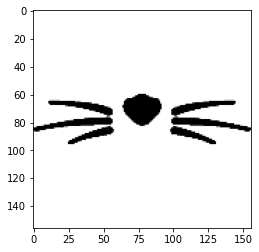

In [5]:
img_sticker = cv2.imread("cat-whiskers.png")
img_sticker = cv2.resize(img_sticker, (w, h))
# print(img_sticker.shape)
plt.imshow(img_sticker)
plt.show()



- 스티커 이미지의 위치가 원래 이미지 영역을 벗어나는 경우가 발생할 수 있어 좌표를 제한하고, 이미지를 자르는 작업 수행

In [6]:
refined_x = x - w // 2
refined_y = y - h
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print(f"(x,y) : ({refined_x},{refined_x})")



(x,y) : (238,238)


## 3. 스티커 이미지 출력
- 스티커에서 사용하고자 하는 영역은 검적으로 표현되어 있고, 나머지 부분은 흰색으로 표현되어 있어 numpy의 where 함수를 사용하여 스티커 이미지 출력

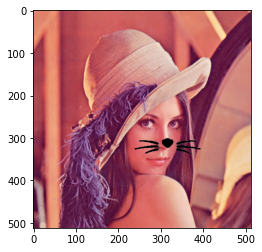

In [7]:
sticker_area = img_bgr[
    refined_y : refined_y + img_sticker.shape[0],
    refined_x : refined_x + img_sticker.shape[1],
]
img_bgr[
    refined_y : refined_y + img_sticker.shape[0],
    refined_x : refined_x + img_sticker.shape[1],
] = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


## 4. 정면이 아닌 경우에 대한 스티커 출력
- 이전 결과에서 확인한 `Lenna` 이미지는 비교적 정면을 바라보고 있으며, 고개를 좌우로 기울이지 않은 상황이었음
  - 하지만 스티커가 얼굴 영역을 벗어남
- 고개를 좌우로 기울이거나 `roll`, 수평 방향으로 고개를 더 돌리는 `yaw`의 경우에는 스티커가 정상적으로 처리되지 않고 이미지가 부자연스러울 수 있음
- 이러한 문제를 해결하고자 코와 얼굴 좌우 윤곽을 기준으로 스티커를 변형하여 출력하는 함수 설계

In [8]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob


detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
img_sticker = cv2.imread("cat-whiskers.png")


- 스티커 이미지가 원본 이미지의 영역을 벗어나지 않도록 범위를 제한하는 함수 정의
- 스티커 이미지에서 불필요한 상단과 하단의 공백을 제거하는 함수 정의

In [9]:
def limit_img(img, x, y, w, h):
    x_limit = x - w // 2
    y_limit = y - h
    if x_limit < 0:
        img = img[:, -x_limit:]
    if y_limit < 0:
        img = img[-y_limit:, :]
    return img


def remove_whitespace(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rev = cv2.bitwise_not(img_gray)
    coords = cv2.findNonZero(img_rev)
    _x, y, _w, h = cv2.boundingRect(coords)
    img = img[y : y + h, :, :]
    return img


- 고양이 수염이 부착될 영역을 양쪽의 얼굴 윤곽과 코의 위치를 기준으로 분할

In [10]:
def get_mesh(landmark, mode="matrix"):
    if mode == "draw":
        vertices1 = np.array(
            [landmark[1], landmark[29], landmark[33], landmark[3]], dtype=np.int32
        )
        vertices2 = np.array(
            [landmark[29], landmark[15], landmark[13], landmark[33]], dtype=np.int32
        )
    else:
        vertices1 = np.array(
            [landmark[1], landmark[3], landmark[29], landmark[33]], dtype=np.int32
        )
        vertices2 = np.array(
            [landmark[29], landmark[33], landmark[15], landmark[13]], dtype=np.int32
        )
    return vertices1, vertices2


# def get_angle(x1, y1, x2, y2):
#     return np.rad2deg(np.arctan((x2 - x1) / (y2 - y1)))


# def rotate_img(img, angle):
#     rows, cols = img.shape[:2]
#     M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1.0)
#     dst = cv2.warpAffine(img, M, (cols, rows), borderValue=(255, 255, 255))
#     return dst


def debug(img):
    img_dst = img.copy()
    dlib_rects = detector_hog(img, 1)

    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_dst, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_dst, point, 2, (0, 255, 255), -1)

    v1, v2 = get_mesh(landmark, mode="draw")
    cv2.polylines(img_dst, [v1], isClosed=True, color=(0, 255, 255))
    cv2.polylines(img_dst, [v2], isClosed=True, color=(0, 255, 255))

    plt.imshow(cv2.cvtColor(img_dst, cv2.COLOR_BGR2RGB))
    plt.show()



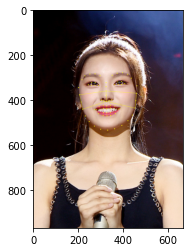

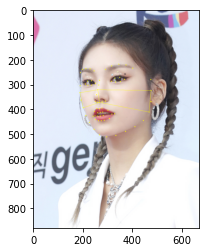

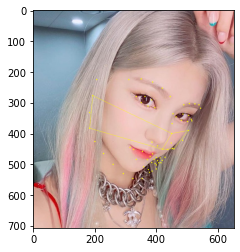

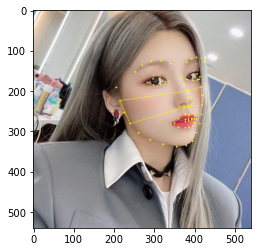

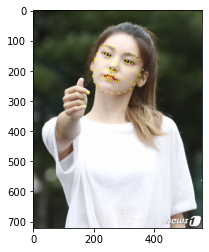

In [11]:
for img in glob.glob("img/*"):
    slanted = cv2.imread(img)
    debug(slanted)

1. 고양이 수염이 부착될 영역을 양쪽의 얼굴 윤곽과 코의 위치를 기준으로 분할
2. 고양이 수염 스티커 이미지 역시 중앙으로 기준으로 분할
3. 스티커 이미지를 부착 영역 이미지의 형태로 변환(Perspective Transform)
4. 얼굴 이미지에 스티커 부착 

In [12]:
def pts_box(pts):
    x_zero = np.min([x for x, _y in pts])
    y_zero = np.min([y for _x, y in pts])
    pts_new = []
    for pnt in pts:
        pts_new.append([pnt[0] - x_zero, pnt[1] - y_zero])
    return pts_new


def transform_image(img, landmark):
    img_tight = remove_whitespace(img)
    half = img_tight.shape[1] // 2
    part1 = img_tight[:, :half]
    part2 = img_tight[:, half:]
    h, w = img_tight.shape[:2]
    pts = [[0, 0], [0, h], [w // 2, 0], [w // 2, h]]
    v1_src = np.float32(pts)
    v2_src = np.float32(pts)

    v1, v2 = get_mesh(landmark)
    v1_dst = np.float32(pts_box(v1))
    v2_dst = np.float32(pts_box(v2))
    m1 = cv2.getPerspectiveTransform(v1_src, v1_dst)
    m2 = cv2.getPerspectiveTransform(v2_src, v2_dst)

    x1, y1, w1, h1 = cv2.boundingRect(v1)
    x2, y2, w2, h2 = cv2.boundingRect(v2)

    part1_t = cv2.warpPerspective(part1, m1, (w1, h1), borderValue=(255, 255, 255))
    part2_t = cv2.warpPerspective(part2, m2, (w2, h2), borderValue=(255, 255, 255))

    return (x1, y1, part1_t), (x2, y2, part2_t)


def attach_sticker(img, img_sticker):
    img_dst = img.copy()
    dlib_rects = detector_hog(img, 1)

    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(img, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # print(landmark[30])
        w = h = dlib_rect.width()
        x = landmark[30][0]
        y = landmark[30][1] + h // 2
        img_sticker = cv2.resize(img_sticker, (w, h))
        img_sticker = limit_img(img_sticker, x, y, w, h)
        p1, p2 = transform_image(img_sticker, landmark)

        for x, y, sticker in [p1, p2]:
            sticker_area = img_dst[y : y + sticker.shape[0], x : x + sticker.shape[1]]
            img_dst[y : y + sticker.shape[0], x : x + sticker.shape[1]] = np.where(
                sticker >= 128, sticker_area, sticker
            ).astype(np.uint8)
    return img_dst


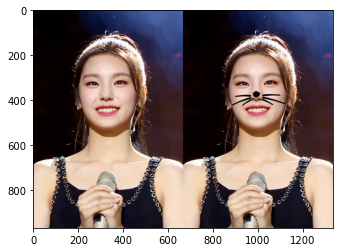

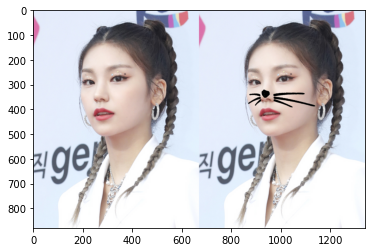

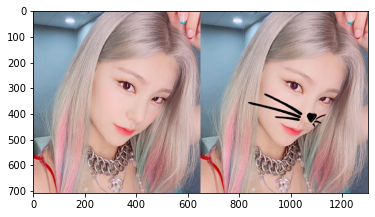

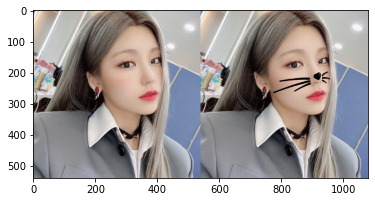

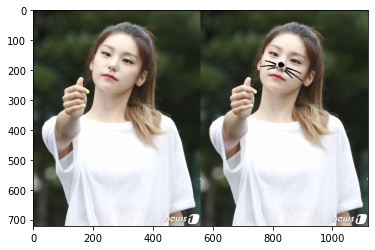

In [13]:

for img in glob.glob("img/*"):
    slanted = cv2.imread(img)
    attatched = attach_sticker(slanted, img_sticker)
    result = cv2.hconcat([slanted, attatched])
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()

### 인물이 멀리 있는 경우, 한 쪽 얼굴이 보이지 않는 경우, 저조도 상황에서의 스티커 출력
- 정면, 정면이 아니라 좌우로 고개를 기울인 `roll`, 고개를 돌린 `yaw`, 복합적인 상황에서도 얼굴 영역에 맞게 스티커를 출력할 수 있었음
- 인물이 멀리 있는 경우(이미지에서 얼굴 영역이 작은 경우), 얼굴의 한쪽면이 전혀 보이지 않는 경우, 이미지가 어두운 경우에 대한 테스트 진행
  - 이미지가 어두운 경우는 동일한 인물의 어두운 상황에서의 이미지를 구하지 못하여 임의의 검은색 이미지를 사용하여 전체적인 밝기를 낮춤

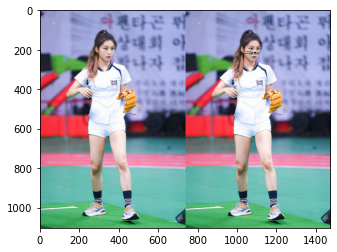

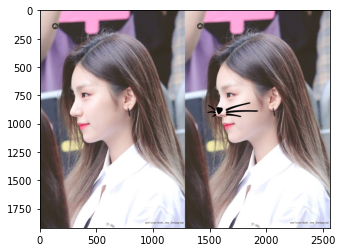

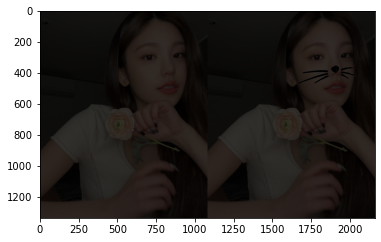

In [14]:
def darkening(img):
    dark = np.zeros_like(img)
    return cv2.addWeighted(img, 0.2, dark, 0.8, 0)


img_list = glob.glob("img_ext/*")
for idx, img in enumerate(img_list):
    slanted = cv2.imread(img)
    if idx == (len(img_list) - 1):
        slanted = darkening(slanted)
    attatched = attach_sticker(slanted, img_sticker)
    result = cv2.hconcat([slanted, attatched])
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()


- 인물이 멀리 있는 경우에도 landmark가 잘 검출되었다면 스티커 부착은 자연스러움
- 얼굴 한 쪽이 전혀 보이지 않는 상황에서는 스티커가 얼굴 영역을 다소 벗어남
  - landmark 검출 결과에서 보이지 않는 쪽의 좌표가 존재하여 발생하는 문제
  - 이러한 상황에서 보이지 않는 쪽의 landmark 좌표를 결과로 내보내지 않는 검출기를 사용하고,  
  이에 따라 좌표가 없는 경우 해당 영역의 스티커는 출력하지 않는 조건을 추가하여 해결해야 함
- 동일한 인물의 저조도에서 촬영된 이미지를 얻을 수 없어 임의로 생성한 검정 이미지를 사용하여 밝기를 낮춘 이미지에서도 스티커 부착은 자연스러움
  - 이미지의 밝기 변경으로 인한 성능 차이는 검출기에 따라 달라지기에, 검출에 성공했다면 스티커 출력에는 문제가 없음

## 5. 결론
- 얼굴의 landmark가 적절히 검출된다면, 스티커 이미지를 합성함에 있어서 문제가 없음
- 촬영 거리가 먼 상황에서도 의도한 대로 결과가 출력됨
- 한 쪽 얼굴이 보이지 않는 경우는, 보이지 않는 쪽의 landmark 좌표가 존재하여 얼굴 영역을 다소 벗어나는 경우 발생
  - 다른 검출기를 사용하거나 직접 검출기 모델을 훈련하여 사용하고, 스티커 합성 함수를 수정하면 개선할 수 있는 사항
- 저조도를 가정하고 임의로 생성한 이미지에서도 의도한 대로 결과가 출력됨

## 루브릭
1. 자기만의 카메라앱 기능 구현을 완수하였다 - 원본에 스티커 사진이 정상적으로 합성되었다
2. 스티커 이미지를 정확한 원본 위치에 반영하였다 - 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다 - 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다

### 루브릭에 대한 자체 평가
1. 원본 사진에 스티커 사진이 정상적으로 합성되었다
2. 정면이 아니라 기울어지거나 측면 얼굴에 대해서도 얼굴을 벗어나지 않고 고양이 수염이 자연스럽게 출력되었다
3. 촬영 거리가 멀어 이미지 속의 인물이 작거나, 한 쪽 얼굴이 전혀 보이지 않는 경우, 그리고 어두운 경우에 대해 실행 결과를 확인하고 개선할 수 있는 방법을 모색하였다